# 데이터 설명

| 필드명        | 설명                  | 비고                                       |
|--------------|-----------------------|------------------------------------------|
| id           | 교유번호              |                                            |
| age          | 나이                  |                                            |
| sex          | 성별                  | 0=여성, 1=남성                            |
| weight       | 체중                  |                                            |
| OP_date      | 수술 날짜             |                                            |
| Recur        | 재발 여부             | 1=재발, 0=마지막 관찰시점까지 재발 안함   |
| Recur_1y     | 1년 내 재발 여부     | 1=1년 내 재발, 0=1년 내 재발 안함         |
| Recur_date   | 재발 날짜             | 재발하지 않은 환자의 경우 마지막 검사 날짜 |
| SBP          | 수축기 혈압           |                                            |
| CA19.9       | 종양표지자 CA19-9값   |                                            |
| CRP          | C-반응 단백질 수치   |                                            |
| CEA          | 종용표지자 CEA 값     |                                            |
| post.CEA     | 수술 직후 CEA 값     |                                            |
| stage        | 암의 병기            | 1, 2, 3                                   |
| smoking      | 흡연 여부            | 1=흡연, 0=비흡연                          |
| obesity      | 비만 여부            | 1=비만, 0=정상                            |
| post.CA19.9  | 수술 직후 CA19-9값  |                                            |
| post.CA19.9.binary | post.CA19.9가 37 초과이면 1, 37 이하이면 0  | |
| post.CA19.9.3grp  | post.CA19.9가 37 이하이면 1, 37초과 100 이히면 2, 70 초과이면 3  | |


In [471]:
import pandas as pd
import tensorflow.keras as keras
D=pd.read_excel("https://data.hossam.kr/F03/biostat.xlsx")
data=pd.DataFrame(D)

## 데이터 확인 및 이상치 처리(간단한)

In [472]:
data.info()
data.drop(columns=["id"],inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  156 non-null    int64         
 1   age                 156 non-null    int64         
 2   sex                 156 non-null    int64         
 3   weight              156 non-null    float64       
 4   OP_date             156 non-null    datetime64[ns]
 5   Recur               156 non-null    int64         
 6   Recur_1y            156 non-null    int64         
 7   Recur_date          156 non-null    datetime64[ns]
 8   SBP                 156 non-null    float64       
 9   CA19.9              156 non-null    float64       
 10  CRP                 156 non-null    float64       
 11  CEA                 156 non-null    float64       
 12  post.CEA            156 non-null    float64       
 13  stage               156 non-null    int64         

## 데이터 구분과 분포확인을 위한 시각화

In [473]:
data.columns

Index(['age', 'sex', 'weight', 'OP_date', 'Recur', 'Recur_1y', 'Recur_date',
       'SBP', 'CA19.9', 'CRP', 'CEA', 'post.CEA', 'stage', 'smoking',
       'obesity', 'post.CA19.9', 'post.CA19.9.binary', 'post.CA19.9.3grp'],
      dtype='object')

#### 매우 근접한 feature
- 'post.CA19.9', 'post.CA19.9.binary', 'post.CA19.9.3grp' 이 셋은 굉장히 연광성이 높음. 따라서 'post.CA19.9'(연속형)만 사용하겠음

In [474]:
data.drop(columns=['post.CA19.9.binary', 'post.CA19.9.3grp'],inplace=True)

### 목적에 따른 구분

In [475]:
target=['OP_date', 'Recur', 'Recur_1y', 'Recur_date']
feature=data.columns.difference(target)

### 타입에 따른 분류 : feature 중에서

In [476]:
category=["sex",'stage', 'smoking','obesity']
numeric=[col for col in feature if col not in category]

### 시각화
다중공선성 정도는 확인할 수 있겠다. 즉 변수끼리 연관성 여부를 간단히 확인

In [477]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]="BM YEONSUNG"

In [478]:
# plt.figure()
# sb.pairplot(data[numeric])
# plt.show()
# plt.close()

In [479]:
numeric

['CA19.9', 'CEA', 'CRP', 'SBP', 'age', 'post.CA19.9', 'post.CEA', 'weight']

#### PairPlot에서 관찰된 문제들
- 1. "CA19.9" : 값이 굉장히 국소적으로 밀집됨
- 2. 'post.CEA' : 마찬가지

이들은 비모수적 처리를 할 가능성이 높음

### Boxplot

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

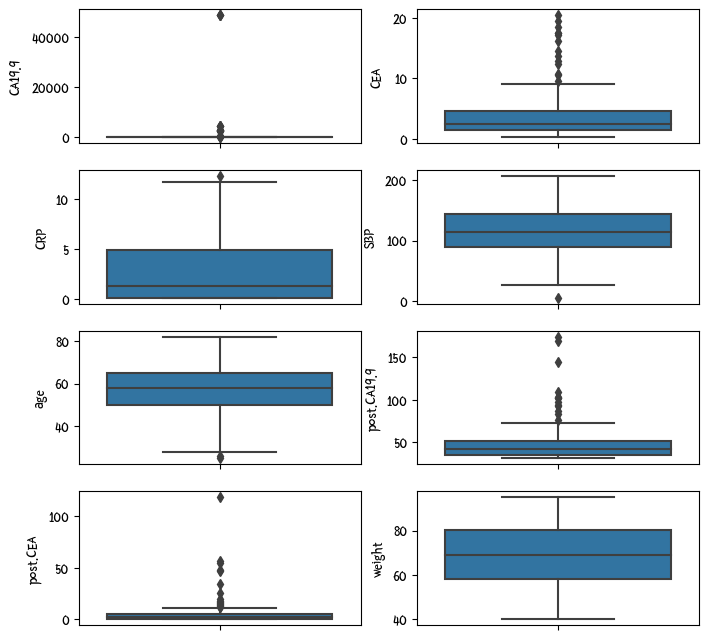

In [480]:
_,a=plt.subplots(4,2,figsize=(8,8))
a=sum(list(map(list,a)),[])
for i,j in enumerate(a):
    sb.boxplot(data=data,y=numeric[i],ax=j)
plt.show()
plt.close()

박스플롯을 본 결과 이전 pairplot에서 본 두개의 컬럼을 제외(값이 극단적으로 분포함을 이미 확인함)            
추가로,         
"post CA19.9"와 "CEA" 에서 너무 많은 이상치를 발견함

## Data preprocessing

### 이상치 처리
* 위에서의 시각화 결과에 따른 feature 들 위주로 처리
* 그 외의 feature들은 이상치 처리를 하지 않음(차후 모델평가 후 고려)

#### CEA

In [481]:
iqr=data["CEA"].quantile(0.75)-data["CEA"].quantile(0.25)
upper_idx=data["CEA"]>data["CEA"].quantile(0.5)+1.5*iqr
lower_idx=data["CEA"]<data["CEA"].quantile(0.5)-1.5*iqr
print("이상치 개수:",data[upper_idx|lower_idx].count()["age"])

이상치 개수: 23


In [482]:
# 최소값이 0보다 크므로 아래의 행동의 근거가 충분
data["CEA"].min()

0.3

이상치가 upper, 즉 높은 값에만 존재함을 boxplot을 통해 확인했고 굉장히 많은 개수가 이상치에 분포되어있음

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CEA', ylabel='Count'>

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


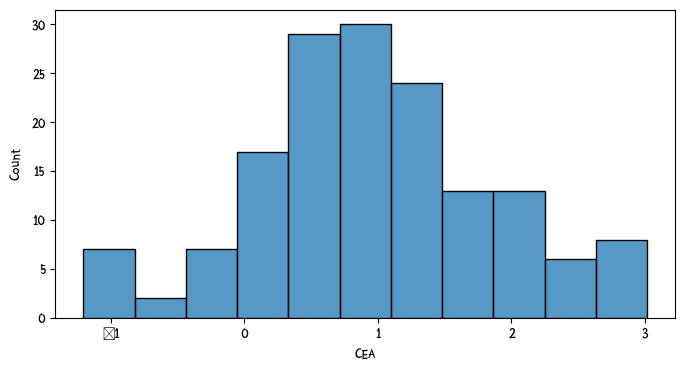

In [483]:
# 오른쪽으로 긴 꼬리 모양이므로 log 변환을 실시한 결과 원하는 모양이 나옴
plt.figure(figsize=(8,4))
sb.histplot(data["CEA"].apply(lambda x: np.log(x)))

In [484]:
# 변환해놓자.
data["CEA"]=data["CEA"].apply(lambda x:np.log(x))

#### post.CA19.9
위의 `CEA`랑 분포가 굉장히 비슷하기 떄문에(이상치가 높은 값에만 존재, 오른쪽으로 긴 꼬리)           
허나 여러 변환(boxcox,로그,제곱근 변환) 시도에도 좋은 모양이 나오지 않음            
비모수적 방법을 이용해서 최대한 variance를 가져가던가 vs 이상치를 특정값으로 변환(? 굉장히 위험) vs 그대로 사용

In [485]:
iqr=data["post.CA19.9"].quantile(0.75)-data["post.CA19.9"].quantile(0.25)
upper_idx=data["post.CA19.9"]>data["post.CA19.9"].quantile(0.5)+1.5*iqr
lower_idx=data["post.CA19.9"]<data["post.CA19.9"].quantile(0.5)-1.5*iqr
print("이상치 개수:",data[upper_idx|lower_idx].count()["age"])

이상치 개수: 18


`drop `하기엔 너무 많은 양          
따라서 변환을 시도해봄

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='post.CA19.9', ylabel='Count'>

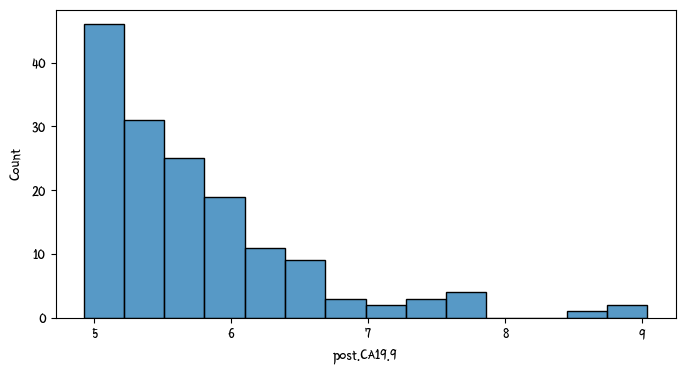

In [486]:
# 오른쪽으로 긴 꼬리 모양이므로 boxcox(lambda=0.2) 변환을 실시한 결과 원하는 모양이 나옴
plt.figure(figsize=(8,4))
sb.histplot(data["post.CA19.9"].apply(lambda x: (x**(1/5)-1))/(1/5))

이상치를 제거한 data_set과 그렇지 않은 data_set2를 준비해서  모델간 비교를 해야함

아래 코드로 drop 시킬것이나, 나머지 전처리가 다 끝나고 해야 편함.

In [487]:
# drop_data : 이상치 제거
ix1=data["post.CA19.9"]>=data["post.CA19.9"].quantile(0.5)-1.5*iqr
ix2=data["post.CA19.9"]<=data["post.CA19.9"].quantile(0.5)+1.5*iqr
drop_data=data[ix1&ix2]

#### CA19.9

In [488]:
data["CA19.9"].describe()

count      156.000000
mean      1158.631410
std       6709.440806
min          1.000000
25%         10.400000
50%         23.150000
75%         61.725000
max      48599.800000
Name: CA19.9, dtype: float64

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CA19.9', ylabel='Count'>

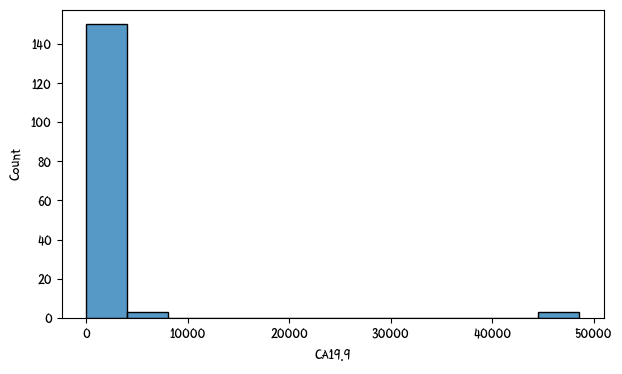

In [489]:
plt.figure(figsize=(7,4))
sb.histplot(data["CA19.9"],bins=12)

In [490]:
iqr=data["CA19.9"].quantile(0.75)-data["CA19.9"].quantile(0.25)
upper=data["CA19.9"]>data["CA19.9"].quantile(0.5)+1.5*iqr
lower=data["CA19.9"]<data["CA19.9"].quantile(0.5)-1.5*iqr
print("이상치의 개수:",data[upper|lower].count()["age"])

이상치의 개수: 22


c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='CA19.9', ylabel='Count'>

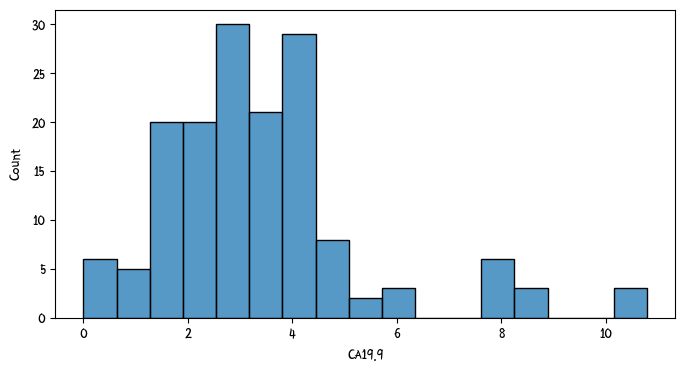

In [491]:
# 로그변환결과
plt.figure(figsize=(8,4))
sb.histplot(data["CA19.9"].apply(lambda x: np.log(x)))

In [492]:
data["CA19.9"]=data["CA19.9"].apply(lambda x:np.log(x))

과정이 위와 같으므로 자세한 설명은 생략

####  post.CEA

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='post.CEA', ylabel='Count'>

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


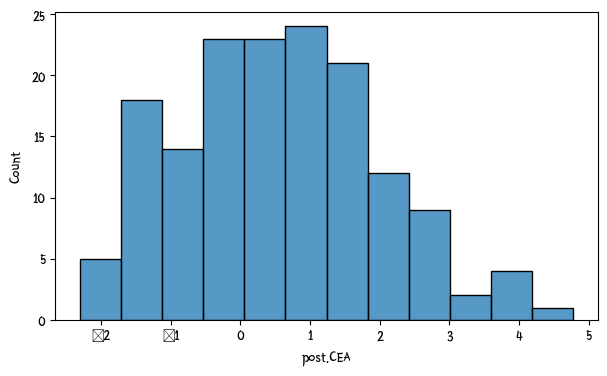

In [493]:
plt.figure(figsize=(7,4))
sb.histplot(data["post.CEA"].apply(lambda x:np.log(x)),bins=12)

다음과 같이 이상치를 모두 처리하였고 하나의 표로 정리하면 다음과 같다

### 전처리 요약

|구분|변수|전처리방법|비고|
|--|--|--|--|
|1|CEA|로그변환||
|2|post.CEA|로그변환||
|3|CA19.9|로그변환||
|4|post.CA19.9|`실패`|데이터셋 분리 후 모델 평가 예정|


## 변수 이해

### Target
|변수|Encoding|
|--|--|
|1년내 재발하지 않음&재발은 했음|1|
|관찰시점까지 재발하지 않음|0|
|1년내 재발|2|

### 위의 Target 변수를 만듬

In [494]:
data["target"]=data["Recur"]+data["Recur_1y"]


In [495]:
data["target"].value_counts()

target
0    72
2    54
1    30
Name: count, dtype: int64

#### 소프트맥스 함수를 위해 One hot encoding을 실시해야함

In [496]:
target_df=pd.get_dummies(data["target"],dtype="int").rename(columns=dict(zip([0,1,2],[f'target({x})' for x in [0,1,2]])))

#### 데이터 프레임 변경(target 추가)

In [497]:
use_df=pd.merge(target_df,data[feature],right_index=True,left_index=True)

In [498]:
use_df

,target(0),target(1),target(2),CA19.9,CEA,CRP,SBP,age,obesity,post.CA19.9,post.CEA,sex,smoking,stage,weight
0,0,1,0,8.409719,1.098612,0.1,144.286869,82,1,36.795194,5.1,1,1,3,73.994588
1,1,0,0,3.602777,0.095310,0.1,108.590964,50,0,32.765043,1.5,0,1,3,64.819694
2,1,0,0,3.602777,2.370244,0.1,5.629379,28,0,31.133072,12.4,1,1,3,63.204675
3,0,1,0,4.172848,0.262364,1.3,143.931300,35,1,36.134051,0.4,1,1,3,52.499192
4,0,1,0,3.642836,1.308333,10.7,172.653143,49,0,33.921657,0.4,1,1,3,72.766264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1,0,0,3.529297,2.862201,0.8,79.698126,54,0,35.861255,25.0,1,0,2,59.109922
152,1,0,0,1.916923,2.140066,3.0,134.097007,62,0,33.238574,1.0,1,0,1,75.948164
153,0,1,0,1.808289,0.875469,0.1,116.632122,51,1,31.965658,1.8,0,0,1,48.533056
154,1,0,0,0.470004,0.832909,1.2,151.178202,51,0,37.996578,0.6,0,0,1,44.724691


## feature selection

### numeric

- 1. PCA

In [499]:
import sklearn.decomposition as skdec
import sklearn.preprocessing as skpre

In [500]:
pca=skdec.PCA(n_components=4)
pca.fit(use_df[numeric])

PCA(n_components=4)

In [501]:
pca_result=pd.DataFrame(pca.explained_variance_)
pca_result["주성분"]=[f'제{i+1} 주성분' for i in range(4)]

In [502]:
pca_result

,0,주성분
0,1490.520203,제1 주성분
1,525.864564,제2 주성분
2,199.200709,제3 주성분
3,137.394036,제4 주성분


In [503]:
test_df=pd.DataFrame(skpre.scale(use_df[numeric])).rename(
    columns=dict(zip([x for x in range(len(numeric))],use_df[numeric].columns)))

In [504]:
pca2=skdec.PCA(n_components=4)
pca2.fit(test_df)

PCA(n_components=4)

In [505]:
pca2_result=pd.DataFrame(pca2.explained_variance_)
pca2_result["주성분"]=[f'제{i+1} 주성분' for i in range(4)]

In [506]:
pca2_result

,0,주성분
0,1.808193,제1 주성분
1,1.532269,제2 주성분
2,1.272832,제3 주성분
3,1.017208,제4 주성분


위의 근거로 주성분(차원축소)를 실행한 결과값을 쓰기에 무리가 있음
* 참고
numerical feature를 z-score scaling한 결과 eigen_value의 값이 1을 넘기는 현상이 발생            
주성분이 원래 데이터의 variance를 가진다는 의미
>결과가 왜곡될 가능성이 생길 수도
* 참고 2
vif 검사를 통해 다중공선성이 높은 변수를 탈락시키는 방법도 있으나..

#### Standard scale

In [507]:
use_df1=use_df.copy()
use_df1[numeric]=skpre.minmax_scale(use_df[numeric])

In [508]:
use_df1.head(3)

,target(0),target(1),target(2),CA19.9,CEA,CRP,SBP,age,obesity,post.CA19.9,post.CEA,sex,smoking,stage,weight
0,0,1,0,0.779300,0.545700,0.0,0.689090,1.000000,1,0.042006,0.042230,1,1,3,0.618083
1,1,0,0,0.333857,0.307923,0.0,0.511691,0.438596,0,0.013955,0.011824,0,1,3,0.451267
2,1,0,0,0.333857,0.847070,0.0,0.000000,0.052632,0,0.002596,0.103885,1,1,3,0.421903


### category
-> 서열척도인가 아닌가는 구분이 필요

In [509]:
ordinal="stage" #암의 진행도
non_ordinal=[x for x in category if x!=ordinal]

In [510]:
for col in non_ordinal:
    print(col,"의 category 개수 : ",use_df1[col].nunique())

sex 의 category 개수 :  2
smoking 의 category 개수 :  2
obesity 의 category 개수 :  2


위의 근거로 One hot encoding이 필요없음

## 데이터 분리

In [511]:
import sklearn.model_selection as skmod
np.random.seed(10)

In [512]:
train1,test1=skmod.train_test_split(use_df1,train_size=0.7,random_state=10)

## 모델 구축 및 학습

In [513]:
import tensorflow.keras as keras

### 모델 구축

In [514]:
def ANN_model(x):
    model=keras.Sequential()
    model.add(keras.layers.Dense(len(feature),activation="relu",input_shape=(len(feature),))) # 입력레이어
    model.add(keras.layers.Dense(x,activation="relu"))
    model.add(keras.layers.Dense(3,activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(),loss="categorical_crossentropy",metrics=["acc"])
    return model

In [515]:
ANN_models={}
for x in range(3,len(feature),2):
    ANN_models[x]=ANN_model(x)

In [516]:
ANN_models[3].summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 12)                156       
                                                                 
 dense_106 (Dense)           (None, 3)                 39        
                                                                 
 dense_107 (Dense)           (None, 3)                 12        
                                                                 
Total params: 207 (828.00 Byte)
Trainable params: 207 (828.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습

In [517]:
use_df

,target(0),target(1),target(2),CA19.9,CEA,CRP,SBP,age,obesity,post.CA19.9,post.CEA,sex,smoking,stage,weight
0,0,1,0,8.409719,1.098612,0.1,144.286869,82,1,36.795194,5.1,1,1,3,73.994588
1,1,0,0,3.602777,0.095310,0.1,108.590964,50,0,32.765043,1.5,0,1,3,64.819694
2,1,0,0,3.602777,2.370244,0.1,5.629379,28,0,31.133072,12.4,1,1,3,63.204675
3,0,1,0,4.172848,0.262364,1.3,143.931300,35,1,36.134051,0.4,1,1,3,52.499192
4,0,1,0,3.642836,1.308333,10.7,172.653143,49,0,33.921657,0.4,1,1,3,72.766264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1,0,0,3.529297,2.862201,0.8,79.698126,54,0,35.861255,25.0,1,0,2,59.109922
152,1,0,0,1.916923,2.140066,3.0,134.097007,62,0,33.238574,1.0,1,0,1,75.948164
153,0,1,0,1.808289,0.875469,0.1,116.632122,51,1,31.965658,1.8,0,0,1,48.533056
154,1,0,0,0.470004,0.832909,1.2,151.178202,51,0,37.996578,0.6,0,0,1,44.724691


In [523]:
results={}
target_col=use_df.columns.difference(feature)
for num in ANN_models:
    results[num]=ANN_models[num].fit(x=train1[feature],y=train1[target_col]
    ,validation_data=(test1[feature],test1[target_col]),epochs=120
    ,callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc',patience=10,verbose=1)])

Epoch 1/120
1/4 [======>.......................] - ETA: 0s - loss: 1.0567 - acc: 0.3125

4/4 [==============================] - 0s 52ms/step - loss: 1.0457 - acc: 0.4220 - val_loss: 1.0478 - val_acc: 0.4043
Epoch 2/120
4/4 [==============================] - 0s 18ms/step - loss: 1.0417 - acc: 0.4587 - val_loss: 1.0448 - val_acc: 0.4043
Epoch 3/120
4/4 [==============================] - 0s 18ms/step - loss: 1.0373 - acc: 0.4679 - val_loss: 1.0424 - val_acc: 0.4468
Epoch 4/120
4/4 [==============================] - 0s 22ms/step - loss: 1.0341 - acc: 0.5138 - val_loss: 1.0405 - val_acc: 0.4894
Epoch 5/120
4/4 [==============================] - 0s 14ms/step - loss: 1.0306 - acc: 0.5321 - val_loss: 1.0389 - val_acc: 0.4681
Epoch 6/120
4/4 [==============================] - 0s 13ms/step - loss: 1.0279 - acc: 0.5596 - val_loss: 1.0374 - val_acc: 0.4681
Epoch 7/120
4/4 [==============================] - 0s 12ms/step - loss: 1.0250 - acc: 0.5780 - val_loss: 1.0359 - val_acc: 0.4681
Epoch 8/120
4/4 [==============================] - 0s 14ms/step - loss: 1.0228 - acc: 0.5780 - val_los

### 결과 확인

전체

In [524]:
results

{3: <keras.src.callbacks.History at 0x188a5135280>,
 5: <keras.src.callbacks.History at 0x188a09cfac0>,
 7: <keras.src.callbacks.History at 0x188a096b7c0>,
 9: <keras.src.callbacks.History at 0x188a09e7e80>,
 11: <keras.src.callbacks.History at 0x188a3c01460>}

In [525]:
pd.DataFrame([{"은닉층":x,"val_acc":results[x].history["val_acc"][-1]} for x in results]).sort_values(by="val_acc",ascending=False)

,은닉층,val_acc
4,11,0.617021
3,9,0.574468
0,3,0.468085
1,5,0.446809
2,7,0.404255


따라서 은닉층의 개수는 11개일때 최고의 정확도를 가짐

### 시각화

In [526]:
results[11].history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

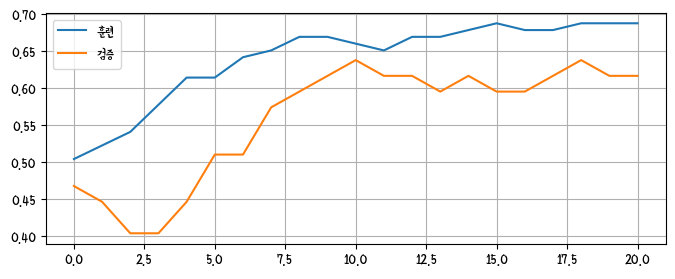

In [535]:
plt.figure(figsize=(8,3))
sb.lineplot(x=range(len(results[11].history["acc"])),y=results[11].history["acc"],label="훈련")
sb.lineplot(x=range(len(results[11].history["acc"])),y=results[11].history["val_acc"],label="검증")
plt.grid()